## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems (Fall 2019)

#### Dr. Haiquan Chen, California State University, Sacramento

In [1]:
# Derrek Gass (219615449)
# Alexander Lee (212490812)
# CSC180 - Intelligent Systems
# Mini-Project 3
# 10-25-19


## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.kaggle.com/c/cifar-10/data

In [3]:
#  Load cifar-10 data and split it to training and test


from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 114s 1us/step


In [4]:
# Check data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [5]:
x_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

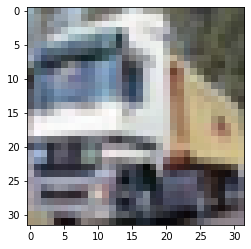

In [6]:
# Let's print out one image in the training set


import matplotlib.pyplot as plt


plt.imshow(x_train[1])

In [7]:
# Convert y_train from 2D to 1D    

y_train = y_train.reshape(50000)

In [8]:
# Check y shape

y_train.shape


# expected output:  (50000,)


(50000,)

In [9]:
y_train[1]

# expected output:  9

9

In [10]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [11]:
y_test.shape

# expected output: (10000,)

(10000,)

In [12]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Convert data from int to float and normalize it


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

### 10 pts: Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense


### You are also encouraged to create multiple models with different numbers of neurons and layers for performance comparison.

In [ ]:
model = Sequential()























In [ ]:
# Print model summary

model.summary()

### 10 pts: Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
























### 10 pts:  Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [ ]:
from sklearn import metrics

































## Part II:   With Transfer learning

In [ ]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


- VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 

- The following cells show you how we can do upsampling for each image to increase its resolution from 32x32 to 64x64 by using the function resize(), which is provided by scikit-image library (https://scikit-image.org/)

In [ ]:
import skimage.transform

new_x_train = []

for image in x_train:
  newImage = skimage.transform.resize(image, (64, 64))      # note that resize() also normalizes your image
  new_x_train.append(newImage)
  

# this code may take about 3 minutes to run

In [ ]:
new_x_train = np.asarray(new_x_train)


In [ ]:
new_x_train.shape


# expected output:  (50000, 64, 64, 3)


In [ ]:
new_x_test = []

for image in x_test:
  newImage = skimage.transform.resize(image, (64, 64))
  new_x_test.append(newImage)


  # this code may take about 2 minutes to run

In [ ]:
new_x_test = np.asarray(new_x_test)

In [ ]:
new_x_test.shape


# expected output:  (10000, 64, 64, 3)

### 10 pts: Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [ ]:
# double check shape

print(y_train.shape)
print(y_test.shape)




# expected output:  (50000, 10)
# expected output:  (10000, 10)

### 5 pts: Now let's load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()

  
# write your code here



















# print out the model summary
model.summary()


### 5 pts: Write your code in the cell below to freeze the weights in each layer in the new model

### 5 pts:  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [ ]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer









### 5 pts:  Write your code in the cell below for compile and fit.   Notice that you should use earlystopping

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

































# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  Let it run for a few epochs. 

### 5 pts:  Write your code in the cell below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [ ]:
from sklearn import metrics





























### 5 pts: Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your created model

### Include your findings in the project report.